In [100]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib
import matplotlib.pyplot as plt
import random
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, precision_recall_curve, auc

In [20]:
# Package requirement

print('numpy version: ', np.__version__)
print('pandas version: ', pd.__version__)
print('pytorch version: ', torch.__version__)
print('torchvision version: ', torchvision.__version__)
print('matplotlib version: ', matplotlib.__version__)
print('sklearn version: ', sklearn.__version__)

numpy version:  1.18.5
pandas version:  1.0.5
pytorch version:  1.7.0
torchvision version:  0.8.1
matplotlib version:  3.2.2
sklearn version:  0.23.1


In [21]:
data = pd.read_csv("data/creditcard.csv")

In [22]:
num_fraud = data[data["Class"] == 1]["Class"].count()
num_total = data["Class"].count()
print("Fraction of fraud is ", num_fraud/num_total)
print("Number of fraud transaction: ", num_fraud)

Fraction of fraud is  0.001727485630620034
Number of fraud transaction:  492


In [23]:
# Set random seed for reproductibility

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [24]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

data['scaled_amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))

data.drop(['Time','Amount'], axis=1, inplace=True)
data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,-0.296653,1.034951
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,0.038986,1.034963
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,0.641096,1.034975
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,-0.167680,1.034975


In [25]:
ytrain = np.array(data['Class']).reshape(-1,1)
ytrain

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [26]:
data.drop('Class', axis=1, inplace=True)
data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,-0.994960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.296653,1.034951
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0.038986,1.034963
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0.641096,1.034975
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,-0.167680,1.034975


In [27]:
xtrain = np.array(data)

scaler = MinMaxScaler()
xtrain = scaler.fit_transform(xtrain)

xtrain

array([[9.35192337e-01, 7.66490419e-01, 8.81364903e-01, ...,
        3.12696634e-01, 5.82379309e-03, 0.00000000e+00],
       [9.78541955e-01, 7.70066651e-01, 8.40298490e-01, ...,
        3.13422663e-01, 1.04705276e-04, 0.00000000e+00],
       [9.35217023e-01, 7.53117667e-01, 8.68140819e-01, ...,
        3.11911316e-01, 1.47389219e-02, 5.78730497e-06],
       ...,
       [9.90904812e-01, 7.64079694e-01, 7.81101998e-01, ...,
        3.12584864e-01, 2.64215395e-03, 9.99976851e-01],
       [9.54208999e-01, 7.72855742e-01, 8.49587129e-01, ...,
        3.15245157e-01, 3.89238944e-04, 9.99976851e-01],
       [9.49231759e-01, 7.65256401e-01, 8.49601462e-01, ...,
        3.13400843e-01, 8.44648509e-03, 1.00000000e+00]])

In [28]:
df_x = pd.DataFrame(xtrain)
df_x

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.510600,...,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.005824,0.000000
1,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,0.505267,...,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.000105,0.000000
2,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,0.513018,...,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0.014739,0.000006
3,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,0.507585,...,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.004807,0.000006
4,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,0.524303,...,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0.002724,0.000012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,0.756448,0.873531,0.666991,0.160317,0.729603,0.236810,0.235393,0.863749,0.528729,0.598850,...,0.564920,0.515249,0.680500,0.313600,0.658558,0.466291,0.433929,0.329840,0.000030,0.999965
284803,0.945845,0.766677,0.872678,0.219189,0.771561,0.273661,0.265504,0.788548,0.482925,0.488530,...,0.564933,0.553153,0.665619,0.245298,0.543855,0.360884,0.417775,0.312038,0.000965,0.999971
284804,0.990905,0.764080,0.781102,0.227202,0.783425,0.293496,0.263547,0.792985,0.477677,0.498692,...,0.565220,0.537005,0.664877,0.468492,0.592824,0.411177,0.416593,0.312585,0.002642,0.999977
284805,0.954209,0.772856,0.849587,0.282508,0.763172,0.269291,0.261175,0.792671,0.476287,0.500464,...,0.565755,0.547353,0.663008,0.398836,0.545958,0.514746,0.418520,0.315245,0.000389,0.999977


In [29]:
# Transfer the numpy array of X and Y to tensor

X = torch.from_numpy(xtrain).float()
Y = torch.from_numpy(ytrain).float()
X.shape

torch.Size([284807, 30])

In [55]:
# Create training dataset set and training data loader

train_dataset = torch.utils.data.TensorDataset(X, Y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True)

In [70]:
# Create Autoencoder class

class VAEs(nn.Module):
    def __init__(self):
        super(VAEs, self).__init__()

        self.enc1 = nn.Linear(in_features=xtrain.shape[1], out_features=18)
        self.enc2_mu = nn.Linear(in_features=18, out_features=6)
        self.enc2_std = nn.Linear(in_features=18, out_features=6)

        self.dec1 = nn.Linear(in_features=6, out_features=18)
        self.dec2 = nn.Linear(in_features=18, out_features=xtrain.shape[1])

    def forward(self, x):

        x = F.relu(self.enc1(x))
        x_mu = F.relu(self.enc2_mu(x))
        x_std = F.relu(self.enc2_std(x))

        x = self.reparameterization(x_mu, x_std)
        x = F.relu(self.dec1(x))
        out = torch.sigmoid(self.dec2(x))
        #out = F.relu(self.dec2(x))

        return out, x_mu, x_std

    def reparameterization(self, x_mu, x_std):

        z_sample = torch.normal(mean=torch.zeros(x_mu.shape[0], 6), std=torch.ones(x_mu.shape[0], 6))
        #z_sample.mul(x_std)
        #z_sample.add(x_mu)
        std = x_std.mul(0.5).exp()
        z_sample.mul_(std).add_(x_mu)

        return z_sample

def total_loss(input, output, x_mu, x_std):

    #reconstruction_loss = F.binary_cross_entropy(input=output, target=input)
    reconstruction_loss = F.mse_loss(output, input)

    #KL_loss = 0.5 * torch.sum(x_mu.pow(2) + x_std.pow(2) - x_std.log() - 1) / x_mu.shape[0]
    dkl = - 0.5 * torch.sum(1 + x_std - x_mu.pow(2) - x_std.exp())
    dkl /= x_mu.shape[0]
    dkl /= 30

    #return reconstruction_loss + KL_loss
    return reconstruction_loss + dkl

In [93]:
# Training function

def training(model, epoch, train_loader):
    train_loss = []
    scheduler = StepLR(optimizer, step_size = 5, gamma = 0.2)
    for e in range(epoch):
        running_loss = 0
        for input, _ in train_loader:
            output, x_mu, x_std = model.forward(input)
            loss = total_loss(input, output, x_mu, x_std)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.item()
        
        scheduler.step()
        ave_loss = running_loss / len(train_loader)
        train_loss.append(ave_loss)
        print('Train loss at {}/{} epoch is {:.8f}, LR: {:.8f}'.format(e+1, epoch, ave_loss, scheduler.get_lr()[0]))
        
    return train_loss

In [94]:
# Generate the model instance and train the model

model = VAEs()
#optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01)

optimizer.zero_grad()
num_epoch = 20
train_loss = training(model, num_epoch, train_loader)

Train loss at 1/20 epoch is 0.00436049, LR: 0.01000000
Train loss at 2/20 epoch is 0.00418033, LR: 0.01000000
Train loss at 3/20 epoch is 0.00417534, LR: 0.01000000
Train loss at 4/20 epoch is 0.00417001, LR: 0.01000000
Train loss at 5/20 epoch is 0.00416593, LR: 0.00040000
Train loss at 6/20 epoch is 0.00416255, LR: 0.00200000
Train loss at 7/20 epoch is 0.00416367, LR: 0.00200000
Train loss at 8/20 epoch is 0.00416314, LR: 0.00200000
Train loss at 9/20 epoch is 0.00416310, LR: 0.00200000
Train loss at 10/20 epoch is 0.00416331, LR: 0.00008000
Train loss at 11/20 epoch is 0.00416193, LR: 0.00040000
Train loss at 12/20 epoch is 0.00416217, LR: 0.00040000
Train loss at 13/20 epoch is 0.00416204, LR: 0.00040000
Train loss at 14/20 epoch is 0.00416295, LR: 0.00040000
Train loss at 15/20 epoch is 0.00416215, LR: 0.00001600
Train loss at 16/20 epoch is 0.00416209, LR: 0.00008000
Train loss at 17/20 epoch is 0.00416261, LR: 0.00008000
Train loss at 18/20 epoch is 0.00416209, LR: 0.00008000
T

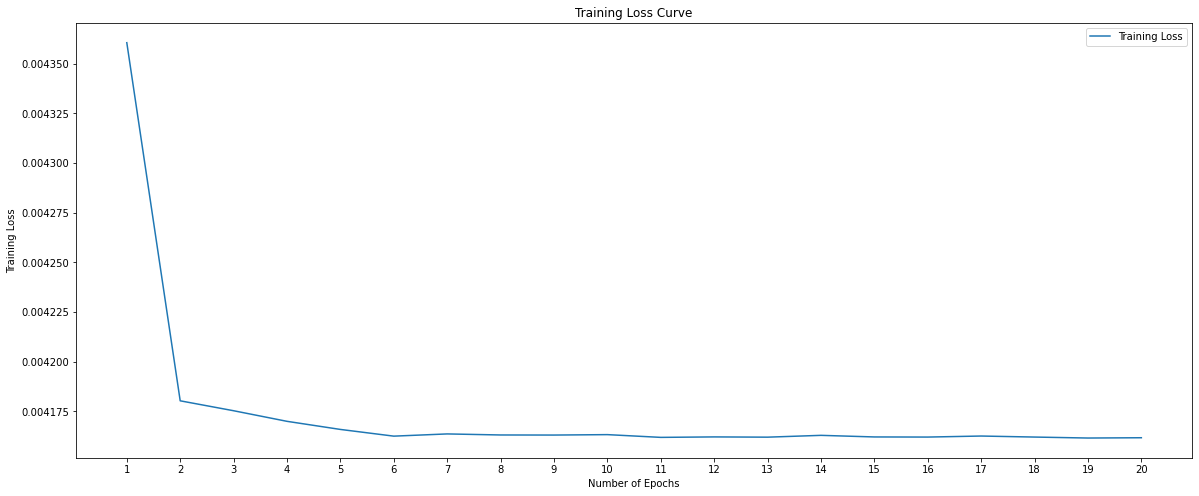

In [95]:
epoch = list(range(1, num_epoch + 1))
plt.figure(figsize = (20, 8))
plt.plot(epoch, train_loss, label = 'Training Loss')
plt.xticks(epoch)
plt.xlabel('Number of Epochs')
plt.ylabel('Training Loss')
#plt.ylim([0.0041, 0.0043])
plt.title('Training Loss Curve')
plt.legend()
plt.show()

In [96]:
# Generate the reconstruction output using the trained model

with torch.no_grad():
    recon = []
    for input, _ in train_loader:
        output, _, _ = model(input)
        for n in range(len(input)):
            recon.append(output[n])
            
reconstruction = []
for item in recon:
    a = item.numpy().tolist()
    reconstruction.append(a)
reconstruction = np.array(reconstruction)

# 1:
recon_error = np.sum(np.abs(xtrain - reconstruction), axis=1)
# 2:
#recon_error = np.sqrt(np.sum((xtrain - reconstruction)**2, axis=1))

ind_err = np.argsort(-recon_error)  # ordering from largest to smallest
ind_err2 = np.argsort(recon_error)  # ordering from smallest to largest

# Metrics

ypred = np.zeros(ytrain.shape, dtype=int)
ypred[ind_err[0:492]] = 1

f1score = f1_score(ytrain, ypred)
precision = precision_score(ytrain, ypred)
recall = recall_score(ytrain, ypred)
accuracy = accuracy_score(ytrain, ypred)


tp = ytrain[ind_err[:num_fraud]].sum()
fp = num_fraud - tp
tn = len(ytrain[ind_err2[:(num_total-num_fraud)]])-ytrain[ind_err2[:(num_total-num_fraud)]].sum()
fn = len(ytrain[ind_err2[:(num_total-num_fraud)]])-tn


accuracy2 = (tp + tn) / (tp + tn + fp + fn)
precision2 = tp / (tp + fp)
recall2 = tp / (tp + fn)
f1score2 = 2 * precision * recall / (precision + recall)


print("F1 score: ", f1score)
print("precision score: ", precision)
print("recall score: ", recall)
print("accuracy score: ", accuracy)
print('--------------------------------')
print("F1 score-2: ", f1score2)
print("precision score-2: ", precision2)
print("recall score-2: ", recall2)
print("accuracy score-2: ", accuracy2)

F1 score:  0.40447154471544716
precision score:  0.40447154471544716
recall score:  0.40447154471544716
accuracy score:  0.9979424663017412
--------------------------------
F1 score-2:  0.40447154471544716
precision score-2:  0.40447154471544716
recall score-2:  0.40447154471544716
accuracy score-2:  0.9979424663017412


In [97]:
print("True positive out of top 492 samples: ", ytrain[ind_err[:492]].sum())
print("Ratio: ", ytrain[ind_err[:492]].sum()/492)
print("True positive out of top 1000 samples: ", ytrain[ind_err[:1000]].sum())
print("Ratio: ", ytrain[ind_err[:1000]].sum()/492)
print("True positive out of top 5000 samples: ", ytrain[ind_err[:5000]].sum())
print("Ratio: ", ytrain[ind_err[:5000]].sum()/492)
print("True positive out of top 10000 samples: ", ytrain[ind_err[:10000]].sum())
print("Ratio: ", ytrain[ind_err[:10000]].sum()/492)
print("True positive out of top 20000 samples: ", ytrain[ind_err[:20000]].sum())
print("Ratio: ", ytrain[ind_err[:20000]].sum()/492)

True positive out of top 492 samples:  199
Ratio:  0.40447154471544716
True positive out of top 1000 samples:  284
Ratio:  0.5772357723577236
True positive out of top 5000 samples:  394
Ratio:  0.8008130081300813
True positive out of top 10000 samples:  413
Ratio:  0.8394308943089431
True positive out of top 20000 samples:  425
Ratio:  0.8638211382113821


In [98]:
prob = recon_error / recon_error.max()
prob

array([0.07790777, 0.07172093, 0.10908053, ..., 0.07525828, 0.10597566,
       0.06557895])

In [101]:
pre, rec, thr = precision_recall_curve(ytrain, prob) 

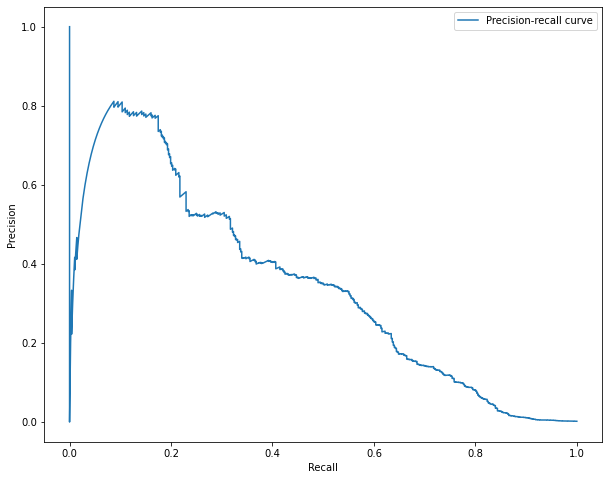

The AUC is 0.34262126966062695


In [102]:
plt.figure(figsize = (10, 8))
plt.plot(rec, pre, label = 'Precision-recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

auc_score = auc(rec, pre)
print('The AUC is {}'. format(auc_score))

In [77]:
pre_arr = []
rec_arr = []
for num_fraud in range(492, 10000):
    tp = ytrain[ind_err[:num_fraud]].sum()
    fp = num_fraud - tp
    tn = len(ytrain[ind_err2[:(num_total-num_fraud)]])-ytrain[ind_err2[:(num_total-num_fraud)]].sum()
    fn = len(ytrain[ind_err2[:(num_total-num_fraud)]])-tn


    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    
    pre_arr.append(precision)
    rec_arr.append(recall)

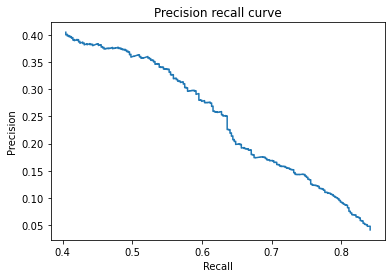

In [84]:
plt.plot(rec_arr, pre_arr)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision recall curve")
plt.show()